## Feature Extraction

In [1]:
from scipy.io import wavfile as wav
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pydub import AudioSegment
from pydub.silence import split_on_silence
from scipy.signal import argrelextrema, find_peaks, peak_prominences, find_peaks_cwt
from sklearn.metrics import accuracy_score

In [2]:
def build_list(artist, clip_number, length):
    i = 1
    artist_list = []
    while i <= length :
        name = artist + "/" + str(clip_number) + "/" +str(i) + ".wav"
        artist_list.append(name)
        i += 1
    return artist_list

def split_silence_chunks(wavfile, silence_length, threshold, file_names_list):
    sound_file = AudioSegment.from_wav(wavfile)
    audio_chunks = split_on_silence(sound_file, 
                        min_silence_len=silence_length,
                        silence_thresh=threshold)
    for i in range (len(audio_chunks)) :
        chunk = audio_chunks[i]
        chunk.export(file_names_list[i], format='wav')
    print("Exported " + str(len(audio_chunks)) + " files")
    
def plot_waves (file, title):
    # Read the wav file (mono)
    samplingFrequency, signalData = wav.read(file)
    
    # Plot the signal read from wav file
    plt.subplot(211)
    plt.title(title)
    plt.plot(signalData[:])
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')

    plt.subplot(212)
    plt.specgram(signalData[:],Fs=samplingFrequency)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    return plt.show()

def get_label(path):
    return path.parts[-3]

# Cooler trick to implement!
#tap['Path'].apply(get_label)


## Visualizing the audio data

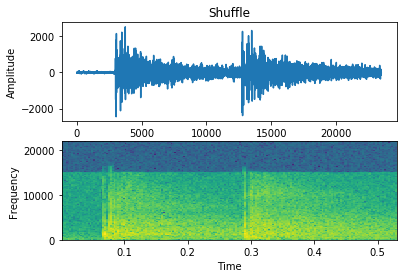

In [3]:
plot_waves('../../Source/Shuffle/1/1.wav', 'Shuffle')

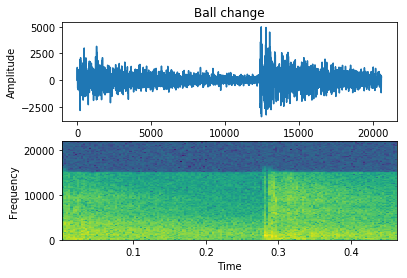

In [4]:
plot_waves('../../Source/Ball_change/1/1.wav', 'Ball change')

In pydub, we can get the array of samples from a given sound.

In [5]:
shuffle = AudioSegment.from_wav('../../Source/Shuffle/1/1.wav')
shuffle.get_array_of_samples()[:15]

array('h', [-16, 7, 12, -3, -2, 6, -7, -7, -1, -27, -41, -25, -31, -37, -17])

The length of the array of samples is equal to the duration in seconds multiplied by the frame (sample) rate

In [6]:
len(shuffle.get_array_of_samples()), shuffle.duration_seconds * shuffle.frame_rate

(23505, 23505.0)

How can I extract relevant information from this *HUGE* array?

## Feature Extraction 

**Approach 1:** Using the amplitude that is greater than or equal to 0

In [7]:
def pos_signal_df (path):
    samplingFrequency, signalData = wav.read(path)
    pos_signalData = signalData[signalData >= 0]
    return pd.DataFrame(pos_signalData)

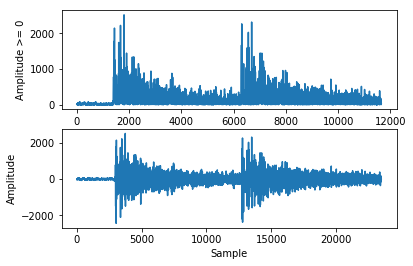

In [8]:
samplingFrequency, signalData = wav.read('../../Source/Shuffle/1/1.wav')

posData = pos_signal_df('../../Source/Shuffle/1/1.wav')

plt.subplot(211)
plt.plot(posData[:])
plt.xlabel('Sample')
plt.ylabel('Amplitude >= 0')  

plt.subplot(212)
plt.plot(signalData[:])
plt.xlabel('Sample')
plt.ylabel('Amplitude');

**Approach 2:** Using the absolute value of the amplitude.

In [9]:
def abs_signal_df(path):
    samplingFrequency, signalData = wav.read(path)
    abs_signalData = signalData[:].copy()
    for i in range (len(signalData[:])):
        if signalData[i] < 0 :
            abs_signalData[i] = np.absolute(signalData[i])
        else : 
            abs_signalData[i] = signalData[i]
    return pd.DataFrame(abs_signalData)

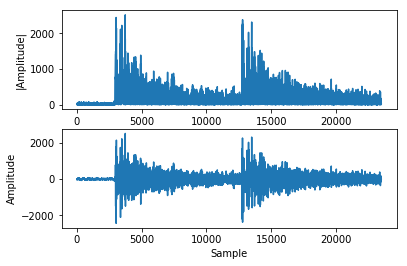

In [10]:
samplingFrequency, signalData = wav.read('../../Source/Shuffle/1/1.wav')
absData = abs_signal_df('../../Source/Shuffle/1/1.wav')

plt.subplot(211)
plt.plot(absData)
plt.xlabel('Sample')
plt.ylabel('|Amplitude|')  

plt.subplot(212)
plt.plot(signalData[:])
plt.xlabel('Sample')
plt.ylabel('Amplitude');

**Thoughts:** While at first glance the two graphs don't look much different, I am more inclined to use Approach 1 since it involves less of a data transformation (artificial, why?), rather narrowing down the data that is already there.

## Peak Analysis

## TO DO!!!!!!!

x : sequence
A signal with peaks.
<br/><br/>height : number or ndarray or sequence, optional
Required height of peaks. Either a number, None, an array matching x or a 2-element sequence of the former. The first element is always interpreted as the minimal and the second, if supplied, as the maximal required height.
<br/><br/>threshold : number or ndarray or sequence, optional
Required threshold of peaks, the vertical distance to its neighbouring samples. Either a number, None, an array matching x or a 2-element sequence of the former. The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.
<br/><br/>distance : number, optional
Required minimal horizontal distance (>= 1) in samples between neighbouring peaks. The removal order is explained in the notes section.
<br/><br/>prominence : number or ndarray or sequence, optional
Required prominence of peaks. Either a number, None, an array matching x or a 2-element sequence of the former. The first element is always interpreted as the minimal and the second, if supplied, as the maximal required prominence.
<br/><br/>width : number or ndarray or sequence, optional
Required width of peaks in samples. Either a number, None, an array matching x or a 2-element sequence of the former. The first element is always interpreted as the minimal and the second, if supplied, as the maximal required prominence.
<br/><br/>wlen : number, optional
Used for calculation of the peaks prominences, thus it is only used if one of the arguments prominence or width is given. See argument wlen in peak_prominences for a full description of its effects.
<br/><br/>rel_height : float, optional
Used for calculation of the peaks width, thus it is only used if width is given. See argument rel_height in peak_widths for a full description of its effects.

## Organizing data in a DataFrame

In [11]:
from pathlib import Path
path_col = []

I'm doing this 2 times, changing the path for each folder (Shuffle, Ball_change).
<br/> Perhaps I'll find a more elegant solution.

In [12]:
pathlist = Path('../../Source/Shuffle').glob('**/*.wav')
for path in pathlist:
    path_col.append(path)

In [13]:
pathlist = Path('../../Source/Ball_change').glob('**/*.wav')
for path in pathlist:
    path_col.append(path)

In [14]:
tap = pd.DataFrame({'Path':path_col})
tap = tap.sort_values(ascending=True, by=['Path'])
tap = tap.reset_index(drop=True)
tap

Path
0   ../../Source/Ball_change/1/1.wav
1   ../../Source/Ball_change/1/2.wav
2   ../../Source/Ball_change/1/3.wav
3   ../../Source/Ball_change/2/1.wav
4   ../../Source/Ball_change/3/1.wav
5   ../../Source/Ball_change/4/1.wav
6   ../../Source/Ball_change/4/2.wav
7       ../../Source/Shuffle/1/1.wav
8       ../../Source/Shuffle/1/2.wav
9       ../../Source/Shuffle/1/3.wav
10      ../../Source/Shuffle/2/1.wav
11      ../../Source/Shuffle/3/1.wav
12      ../../Source/Shuffle/4/1.wav
13      ../../Source/Shuffle/4/2.wav

### Add labels by hand (Shuffle = 1, Ball_change = 0)
(Is it possible to use the path names for this task?)
<br/> **YES!** Thanks, Manuel!

In [15]:
#tap['Labels'] = [0,0,0,0,0,0,0,1,1,1,1,1,1,1]

### Add labels like a pro

In [16]:
tap['Labels'] = [get_label(tap.loc[idx,'Path']) for idx in range(len(tap))]

Pimp out DataFrame with other relevant details
<br/> Single line loops 'cause I'm a *gangsta*!

In [17]:
tap['Length'] = [AudioSegment.from_wav(str(tap.loc[idx, 'Path'])).duration_seconds for idx in range(len(tap))] 
tap['Channels'] = [AudioSegment.from_wav(str(tap.loc[idx, 'Path'])).channels for idx in range(len(tap))]
tap['Sample_rate'] = [AudioSegment.from_wav(str(tap.loc[idx, 'Path'])).frame_rate for idx in range(len(tap))]
tap['Bit_depth'] = [AudioSegment.from_wav(str(tap.loc[idx, 'Path'])).sample_width*8 for idx in range(len(tap))]
tap['Mean'] = [pd.DataFrame(np.array(AudioSegment.from_wav(str(tap.loc[idx, 'Path'])).get_array_of_samples())).
               mean().item() for idx in range(len(tap))]
tap['Std'] = [pd.DataFrame(np.array(AudioSegment.from_wav(str(tap.loc[idx, 'Path'])).get_array_of_samples())).
               std().item() for idx in range(len(tap))]
tap['Min'] = [pd.DataFrame(np.array(AudioSegment.from_wav(str(tap.loc[idx, 'Path'])).get_array_of_samples())).
               min().item() for idx in range(len(tap))]
tap['Q_1'] = [pd.DataFrame(np.array(AudioSegment.from_wav(str(tap.loc[idx, 'Path'])).get_array_of_samples())).
               describe().iloc[4].item() for idx in range(len(tap))]
tap['Q_2'] = [pd.DataFrame(np.array(AudioSegment.from_wav(str(tap.loc[idx, 'Path'])).get_array_of_samples())).
               describe().iloc[5].item() for idx in range(len(tap))]
tap['Q_3'] = [pd.DataFrame(np.array(AudioSegment.from_wav(str(tap.loc[idx, 'Path'])).get_array_of_samples())).
               describe().iloc[6].item() for idx in range(len(tap))]
tap['Max'] = [pd.DataFrame(np.array(AudioSegment.from_wav(str(tap.loc[idx, 'Path'])).get_array_of_samples())).
               max().item() for idx in range(len(tap))]

In [18]:
tap

Path       Labels    Length  Channels  \
0   ../../Source/Ball_change/1/1.wav  Ball_change  0.466984         1   
1   ../../Source/Ball_change/1/2.wav  Ball_change  0.566984         1   
2   ../../Source/Ball_change/1/3.wav  Ball_change  0.566984         1   
3   ../../Source/Ball_change/2/1.wav  Ball_change  1.500000         1   
4   ../../Source/Ball_change/3/1.wav  Ball_change  0.400000         1   
5   ../../Source/Ball_change/4/1.wav  Ball_change  0.624989         1   
6   ../../Source/Ball_change/4/2.wav  Ball_change  0.700000         1   
7       ../../Source/Shuffle/1/1.wav      Shuffle  0.532993         1   
8       ../../Source/Shuffle/1/2.wav      Shuffle  0.632993         1   
9       ../../Source/Shuffle/1/3.wav      Shuffle  0.632993         1   
10      ../../Source/Shuffle/2/1.wav      Shuffle  0.500000         1   
11      ../../Source/Shuffle/3/1.wav      Shuffle  0.900000         1   
12      ../../Source/Shuffle/4/1.wav      Shuffle  0.774989         1   
13      ../../Source/Shuffle/4/2.wav      Shuffle  0.400000         1   

    Sample_rate  Bit_depth       Mean          Std    Min    Q_1   Q_2  \
0         44100         16   0.347091   608.523564  -3433 -299.0  -5.0   
1         44100         16  -0.649896   471.699404  -3582 -202.0  -6.0   
2         44100         16  -0.393257   488.133618  -3819 -194.0  -1.0   
3         44100         16   0.261391   921.549427 -15009 -540.0 -16.0   
4         44100         16  -0.151190  2357.102638 -26813 -926.0  13.5   
5         44100         16 -35.885422  1484.873559  -8882 -883.0 -27.5   
6         44100         16 -49.918756  1272.652878  -9992 -531.0 -40.0   
7         44100         16  -0.392597   294.696634  -2446 -126.0  -2.0   
8         44100         16  -0.365359   352.558903  -3448 -136.0  -1.0   
9         44100         16  -0.455597   319.234561  -2602 -122.0  -2.0   
10        44100         16  -2.364354  1144.741640 -16200 -345.0   1.0   
11        44100         16   9.236987  2730.626928 -26979 -802.0   1.0   
12        44100         16 -41.917518  1021.160191  -8892 -541.0 -49.0   
13        44100         16 -39.649320  1051.165307  -9437 -587.0 -35.0   

       Q_3    Max  
0   287.00   4986  
1   196.00   4065  
2   190.00   4477  
3   554.00  15436  
4   920.25  23822  
5   779.00   9587  
6   449.00   9455  
7   124.00   2520  
8   135.00   3257  
9   125.00   3132  
10  344.00  16177  
11  818.00  23417  
12  431.00   8293  
13  520.00   8204

## Add features from positive signal transformation

In [19]:
tap['Mean_P'] = [pos_signal_df(tap.loc[idx, 'Path']).mean().item() for idx in range(len(tap))]
tap['Std_P'] = [pos_signal_df(tap.loc[idx, 'Path']).std().item() for idx in range(len(tap))]
tap['Q_1_P'] = [pos_signal_df(tap.loc[idx, 'Path']).
               describe().iloc[4].item() for idx in range(len(tap))]
tap['Q_2_P'] = [pos_signal_df(tap.loc[idx, 'Path']).
               describe().iloc[5].item() for idx in range(len(tap))]
tap['Q_3_P'] = [pos_signal_df(tap.loc[idx, 'Path']).
               describe().iloc[6].item() for idx in range(len(tap))]

# I think it's redundant to keep these "features"
#tap['Min_P'] = [pos_signal_df(tap.loc[idx, 'Path']).min().item() for idx in range(len(tap))]
#tap['Max_P'] = [pos_signal_df(tap.loc[idx, 'Path']).max().item() for idx in range(len(tap))]

In [20]:
tap

Path       Labels    Length  Channels  \
0   ../../Source/Ball_change/1/1.wav  Ball_change  0.466984         1   
1   ../../Source/Ball_change/1/2.wav  Ball_change  0.566984         1   
2   ../../Source/Ball_change/1/3.wav  Ball_change  0.566984         1   
3   ../../Source/Ball_change/2/1.wav  Ball_change  1.500000         1   
4   ../../Source/Ball_change/3/1.wav  Ball_change  0.400000         1   
5   ../../Source/Ball_change/4/1.wav  Ball_change  0.624989         1   
6   ../../Source/Ball_change/4/2.wav  Ball_change  0.700000         1   
7       ../../Source/Shuffle/1/1.wav      Shuffle  0.532993         1   
8       ../../Source/Shuffle/1/2.wav      Shuffle  0.632993         1   
9       ../../Source/Shuffle/1/3.wav      Shuffle  0.632993         1   
10      ../../Source/Shuffle/2/1.wav      Shuffle  0.500000         1   
11      ../../Source/Shuffle/3/1.wav      Shuffle  0.900000         1   
12      ../../Source/Shuffle/4/1.wav      Shuffle  0.774989         1   
13      ../../Source/Shuffle/4/2.wav      Shuffle  0.400000         1   

    Sample_rate  Bit_depth       Mean          Std    Min    Q_1   Q_2  \
0         44100         16   0.347091   608.523564  -3433 -299.0  -5.0   
1         44100         16  -0.649896   471.699404  -3582 -202.0  -6.0   
2         44100         16  -0.393257   488.133618  -3819 -194.0  -1.0   
3         44100         16   0.261391   921.549427 -15009 -540.0 -16.0   
4         44100         16  -0.151190  2357.102638 -26813 -926.0  13.5   
5         44100         16 -35.885422  1484.873559  -8882 -883.0 -27.5   
6         44100         16 -49.918756  1272.652878  -9992 -531.0 -40.0   
7         44100         16  -0.392597   294.696634  -2446 -126.0  -2.0   
8         44100         16  -0.365359   352.558903  -3448 -136.0  -1.0   
9         44100         16  -0.455597   319.234561  -2602 -122.0  -2.0   
10        44100         16  -2.364354  1144.741640 -16200 -345.0   1.0   
11        44100         16   9.236987  2730.626928 -26979 -802.0   1.0   
12        44100         16 -41.917518  1021.160191  -8892 -541.0 -49.0   
13        44100         16 -39.649320  1051.165307  -9437 -587.0 -35.0   

       Q_3    Max       Mean_P        Std_P  Q_1_P  Q_2_P    Q_3_P  
0   287.00   4986   424.520494   465.533133  126.0  290.5   565.00  
1   196.00   4065   313.689013   370.624902   75.5  204.0   418.00  
2   190.00   4477   311.102537   382.656037   59.0  191.0   422.75  
3   554.00  15436   687.599178   626.287555  259.0  565.0   969.00  
4   920.25  23822  1496.901294  1836.470622  380.0  910.0  1928.00  
5   779.00   9587  1081.651192   989.230736  361.0  797.0  1513.00  
6   449.00   9455   800.395346   965.616231  194.0  499.0  1080.00  
7   124.00   2520   191.838040   224.725100   43.0  126.0   257.00  
8   135.00   3257   219.751685   273.041335   43.0  135.0   287.00  
9   125.00   3132   202.167100   246.210055   50.0  126.0   259.00  
10  344.00  16177   587.545726   993.309667  120.0  342.0   695.00  
11  818.00  23417  1706.546127  2152.119002  252.0  813.5  2419.25  
12  431.00   8293   718.865007   775.733438  194.0  502.0   990.00  
13  520.00   8204   725.522442   718.368740  255.0  542.0   968.00

## Add features from absolute value signal transformation

In [21]:
tap['Mean_A'] = [abs_signal_df(tap.loc[idx, 'Path']).mean().item() for idx in range(len(tap))]
tap['Std_A'] = [abs_signal_df(tap.loc[idx, 'Path']).std().item() for idx in range(len(tap))]
tap['Q_1_A'] = [abs_signal_df(tap.loc[idx, 'Path']).
               describe().iloc[4].item() for idx in range(len(tap))]
tap['Q_2_A'] = [abs_signal_df(tap.loc[idx, 'Path']).
               describe().iloc[5].item() for idx in range(len(tap))]
tap['Q_3_A'] = [abs_signal_df(tap.loc[idx, 'Path']).
               describe().iloc[6].item() for idx in range(len(tap))]

In [22]:
tap

Path       Labels    Length  Channels  \
0   ../../Source/Ball_change/1/1.wav  Ball_change  0.466984         1   
1   ../../Source/Ball_change/1/2.wav  Ball_change  0.566984         1   
2   ../../Source/Ball_change/1/3.wav  Ball_change  0.566984         1   
3   ../../Source/Ball_change/2/1.wav  Ball_change  1.500000         1   
4   ../../Source/Ball_change/3/1.wav  Ball_change  0.400000         1   
5   ../../Source/Ball_change/4/1.wav  Ball_change  0.624989         1   
6   ../../Source/Ball_change/4/2.wav  Ball_change  0.700000         1   
7       ../../Source/Shuffle/1/1.wav      Shuffle  0.532993         1   
8       ../../Source/Shuffle/1/2.wav      Shuffle  0.632993         1   
9       ../../Source/Shuffle/1/3.wav      Shuffle  0.632993         1   
10      ../../Source/Shuffle/2/1.wav      Shuffle  0.500000         1   
11      ../../Source/Shuffle/3/1.wav      Shuffle  0.900000         1   
12      ../../Source/Shuffle/4/1.wav      Shuffle  0.774989         1   
13      ../../Source/Shuffle/4/2.wav      Shuffle  0.400000         1   

    Sample_rate  Bit_depth       Mean          Std    Min    Q_1   ...     \
0         44100         16   0.347091   608.523564  -3433 -299.0   ...      
1         44100         16  -0.649896   471.699404  -3582 -202.0   ...      
2         44100         16  -0.393257   488.133618  -3819 -194.0   ...      
3         44100         16   0.261391   921.549427 -15009 -540.0   ...      
4         44100         16  -0.151190  2357.102638 -26813 -926.0   ...      
5         44100         16 -35.885422  1484.873559  -8882 -883.0   ...      
6         44100         16 -49.918756  1272.652878  -9992 -531.0   ...      
7         44100         16  -0.392597   294.696634  -2446 -126.0   ...      
8         44100         16  -0.365359   352.558903  -3448 -136.0   ...      
9         44100         16  -0.455597   319.234561  -2602 -122.0   ...      
10        44100         16  -2.364354  1144.741640 -16200 -345.0   ...      
11        44100         16   9.236987  2730.626928 -26979 -802.0   ...      
12        44100         16 -41.917518  1021.160191  -8892 -541.0   ...      
13        44100         16 -39.649320  1051.165307  -9437 -587.0   ...      

         Mean_P        Std_P  Q_1_P  Q_2_P    Q_3_P       Mean_A        Std_A  \
0    424.520494   465.533133  126.0  290.5   565.00   420.091871   440.244589   
1    313.689013   370.624902   75.5  204.0   418.00   306.435210   358.600692   
2    311.102537   382.656037   59.0  191.0   422.75   310.301352   376.807383   
3    687.599178   626.287555  259.0  565.0   969.00   677.213500   625.002687   
4   1496.901294  1836.470622  380.0  910.0  1928.00  1508.084070  1811.487336   
5   1081.651192   989.230736  361.0  797.0  1513.00  1099.327262   998.785772   
6    800.395346   965.616231  194.0  499.0  1080.00   805.303207   986.713254   
7    191.838040   224.725100   43.0  126.0   257.00   190.573835   224.780622   
8    219.751685   273.041335   43.0  135.0   287.00   219.935984   275.543723   
9    202.167100   246.210055   50.0  126.0   259.00   200.949740   248.049728   
10   587.545726   993.309667  120.0  342.0   695.00   592.095057   979.717591   
11  1706.546127  2152.119002  252.0  813.5  2419.25  1700.318922  2136.644908   
12   718.865007   775.733438  194.0  502.0   990.00   696.020101   748.376315   
13   725.522442   718.368740  255.0  542.0   968.00   741.563492   746.038250   

    Q_1_A  Q_2_A    Q_3_A  
0   131.0  293.0   560.00  
1    75.0  199.0   408.00  
2    62.0  192.0   420.00  
3   261.0  546.0   940.00  
4   385.0  923.0  1965.25  
5   372.0  831.0  1533.00  
6   194.0  492.0  1065.00  
7    42.0  125.0   255.00  
8    45.0  135.0   287.00  
9    50.0  124.0   257.00  
10  121.0  345.0   702.00  
11  256.0  810.0  2411.75  
12  192.0  491.0   967.00  
13  260.0  555.0   982.00  

[14 rows x 23 columns]

## Add values from peak analysis

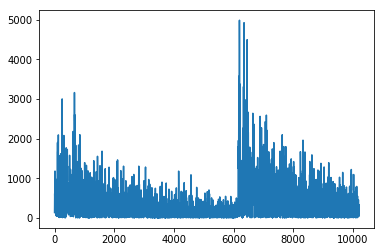

In [23]:
import numpy as np
from scipy.signal import argrelmax, find_peaks, find_peaks_cwt
from matplotlib.pyplot import *

x = pos_signal_df(tap.loc[0, 'Path']).values.ravel()

plot(x)

show()

## Quick and dirty test with mini-dataset

In [24]:
data = tap.iloc[:,6:].values
labels = tap['Labels']

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)

In [27]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [28]:
predict = logreg.predict(X_test)
proba = logreg.predict_proba(X_test)

In [29]:
results = pd.DataFrame()
results['Predict'] = predict
results['True'] = y_test.values
results['Prob_0'] = proba[:,0]

In [30]:
results

Predict         True    Prob_0
0  Ball_change      Shuffle  0.996589
1  Ball_change      Shuffle  1.000000
2  Ball_change  Ball_change  1.000000
3  Ball_change      Shuffle  0.993015
4  Ball_change  Ball_change  0.994643

In [31]:
print('Accuracy score: ' + str(accuracy_score(y_test, predict)))

Accuracy score: 0.4


This **sucks**. It's even *worse* than randomly guessing. I need a new approach for feature extraction.